#Group Assignment - Iranian Churn Analysis

## Connect with google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

In [ ]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BUSI 652/data/Customer Churn.csv")
df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


In [ ]:
# Add a unique customer ID column
df.insert(0, 'Customer ID', range(1, len(df) + 1))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Customer ID              3150 non-null   int64  
 1   Call  Failure            3150 non-null   int64  
 2   Complains                3150 non-null   int64  
 3   Subscription  Length     3150 non-null   int64  
 4   Charge  Amount           3150 non-null   int64  
 5   Seconds of Use           3150 non-null   int64  
 6   Frequency of use         3150 non-null   int64  
 7   Frequency of SMS         3150 non-null   int64  
 8   Distinct Called Numbers  3150 non-null   int64  
 9   Age Group                3150 non-null   int64  
 10  Tariff Plan              3150 non-null   int64  
 11  Status                   3150 non-null   int64  
 12  Age                      3150 non-null   int64  
 13  Customer Value           3150 non-null   float64
 14  Churn                   

In [ ]:
df.shape

(3150, 15)

In [ ]:
# Convert to appropriate data types
df['Customer ID'] = df['Customer ID'].astype(str)
df['Complains'] = df['Complains'].astype('category')  # Binary (0, 1)
df['Tariff Plan'] = df['Tariff Plan'].astype('category')  # Binary (1, 2)
df['Status'] = df['Status'].astype('category')  # Binary (1, 2)
df['Churn'] = df['Churn'].astype('category')  # Binary (0, 1)

df['Charge  Amount'] = df['Charge  Amount'].astype('category')  # Ordinal (0 to 9)
df['Age Group'] = df['Age Group'].astype('category')  # Ordinal (1 to 5)

print(df.dtypes)

Customer ID                  object
Call  Failure                 int64
Complains                  category
Subscription  Length          int64
Charge  Amount             category
Seconds of Use                int64
Frequency of use              int64
Frequency of SMS              int64
Distinct Called Numbers       int64
Age Group                  category
Tariff Plan                category
Status                     category
Age                           int64
Customer Value              float64
Churn                      category
dtype: object


### Summary Statistics

In [ ]:
# Summary Statistics
summary_stats = df.describe().transpose().round(4)
print(summary_stats)

                          count       mean        std   min        25%  \
Call  Failure            3150.0     7.6279     7.2639   0.0     1.0000   
Subscription  Length     3150.0    32.5419     8.5735   3.0    30.0000   
Seconds of Use           3150.0  4472.4597  4197.9087   0.0  1391.2500   
Frequency of use         3150.0    69.4606    57.4133   0.0    27.0000   
Frequency of SMS         3150.0    73.1749   112.2376   0.0     6.0000   
Distinct Called Numbers  3150.0    23.5098    17.2173   0.0    10.0000   
Age                      3150.0    30.9984     8.8311  15.0    25.0000   
Customer Value           3150.0   470.9729   517.0154   0.0   113.8012   

                             50%        75%       max  
Call  Failure               6.00    12.0000     36.00  
Subscription  Length       35.00    38.0000     47.00  
Seconds of Use           2990.00  6478.2500  17090.00  
Frequency of use           54.00    95.0000    255.00  
Frequency of SMS           21.00    87.0000    522.00

In [ ]:
summary_stats.to_csv('summary_statistics.csv')

### Feature Distribution

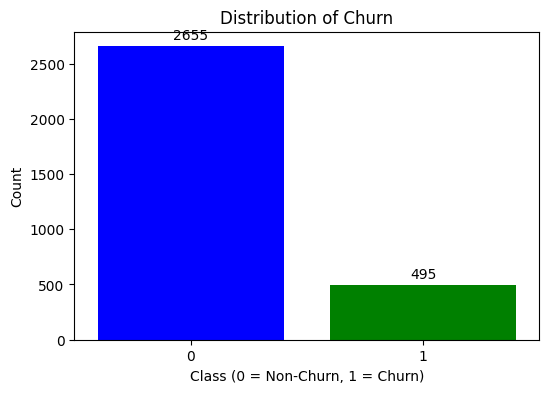

In [ ]:
# Function to add count labels on the bars
def add_count_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=10, color='black',
                    xytext=(0, 5), textcoords='offset points')

# Plot the distribution of the 'Churn' (target) variable
plt.figure(figsize=(6, 4))
ax_shape = sns.countplot(x='Churn', data=df)
for p, color in zip(ax_shape.patches, ['blue', 'green']):
    p.set_facecolor(color)
plt.title('Distribution of Churn')
plt.xlabel('Class (0 = Non-Churn, 1 = Churn)')
plt.ylabel('Count')
add_count_labels(ax_shape)
plt.show()

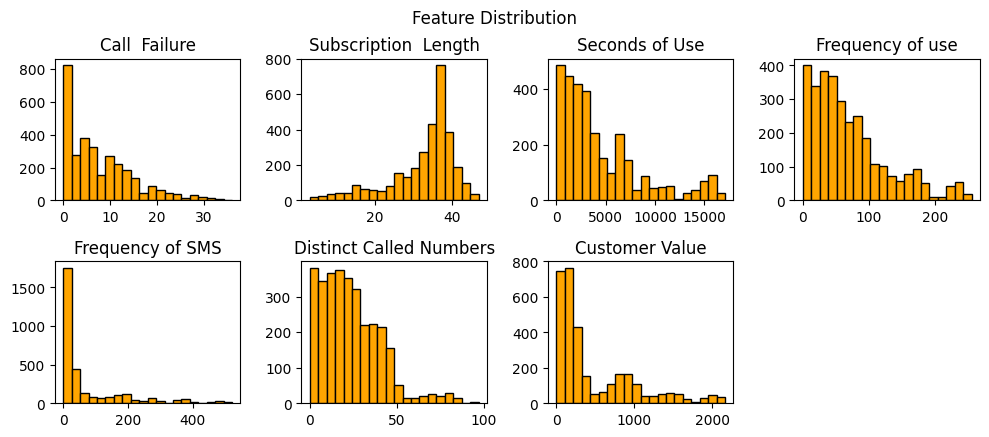

In [ ]:
features = ['Call  Failure', 'Subscription  Length',
            'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
            'Distinct Called Numbers', 'Customer Value']
plt.figure(figsize=(10, 6))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 4, i)
    plt.hist(df[feature], bins=20, color='orange', edgecolor='black')
    plt.title(feature)
    plt.tight_layout()
plt.suptitle('Feature Distribution', y=1.02)
plt.show()

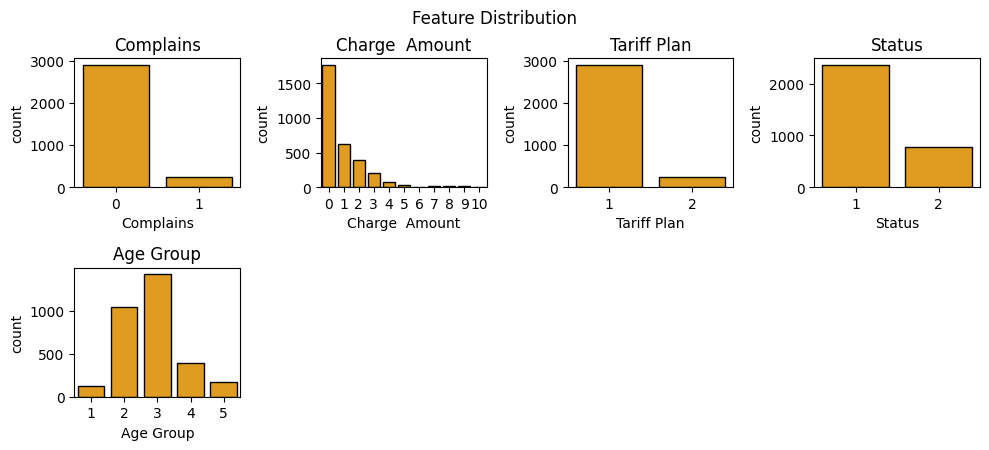

In [ ]:
features = ['Complains', 'Charge  Amount', 'Tariff Plan', 'Status','Age Group']
plt.figure(figsize=(10, 6))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 4, i)
    unique_values = df[feature].unique()  # Get unique values in the dataset for the feature
    sns.countplot(x=df[feature], order=sorted(unique_values), color='orange', edgecolor='black')  # Plot in sorted order
    plt.title(feature)
    plt.tight_layout()
plt.suptitle('Feature Distribution', y=1.02)
plt.show()

### Correlation Matrix

                         Customer ID  Call  Failure  Complains  \
Customer ID                     1.00           0.25      -0.03   
Call  Failure                   0.25           1.00       0.15   
Complains                      -0.03           0.15       1.00   
Subscription  Length            0.07           0.17      -0.02   
Charge  Amount                  0.15           0.59      -0.03   
Seconds of Use                  0.02           0.50      -0.10   
Frequency of use                0.04           0.57      -0.09   
Frequency of SMS                0.02          -0.02      -0.11   
Distinct Called Numbers         0.04           0.50      -0.06   
Age Group                       0.11           0.05       0.02   
Tariff Plan                     0.02           0.19       0.00   
Status                          0.01          -0.11       0.27   
Age                             0.09           0.04       0.00   
Customer Value                  0.00           0.12      -0.13   
Churn     

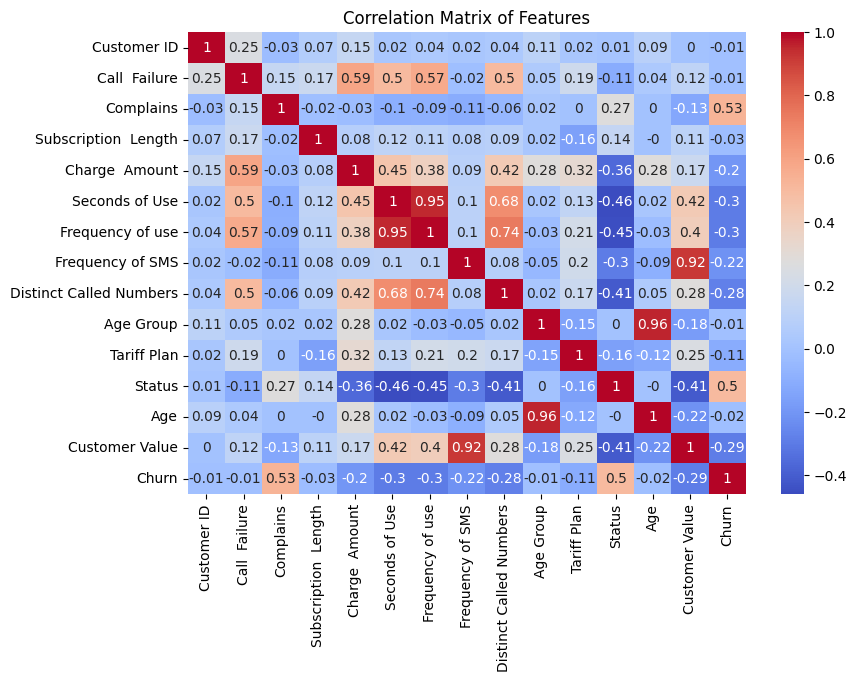

In [ ]:
# Correlation matrix
correlation_matrix = df.corr().round(2)
print(correlation_matrix)

plt.figure(figsize=(9, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

## 2. Data Preprocessing

### Handling Missing Values

In [ ]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
print(missing_values)

Customer ID                0
Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64


### Removing duplicate value (if any)

In [ ]:
print(df.duplicated().value_counts())
df.drop_duplicates(inplace =True)

False    3150
Name: count, dtype: int64


### Outlier Detection and Treatment

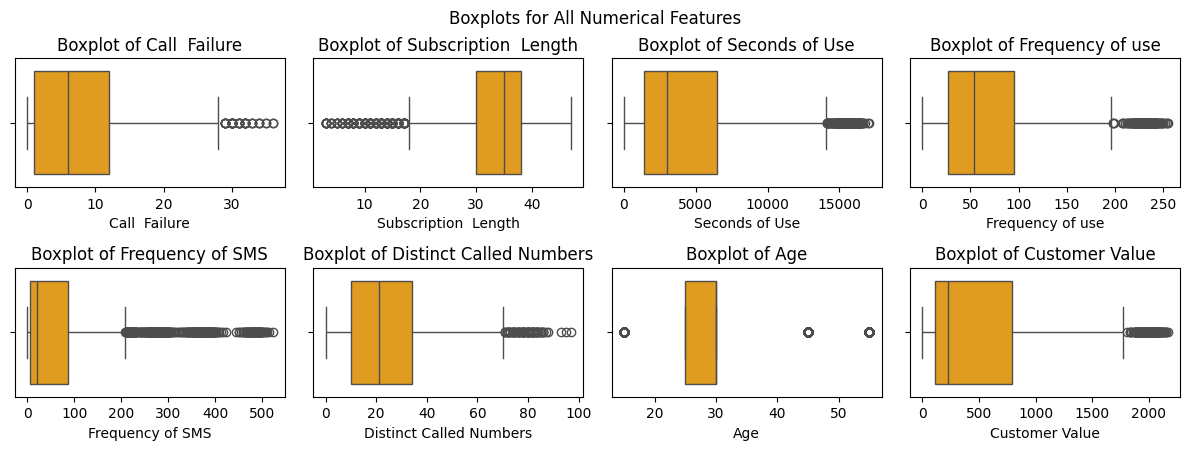

In [ ]:
# Select numerical features (excluding categorical features)
numerical_features = df.select_dtypes(include=[np.number]).columns

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Create subplots for each numerical feature
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features) // 4+ 1, 4, i)
    sns.boxplot(x=df[feature], color='orange')  # Draw boxplot for each feature
    plt.title(f'Boxplot of {feature}')
    plt.tight_layout()  # Adjust layout

# Show the plot
plt.suptitle('Boxplots for All Numerical Features', y=1.02)
plt.show()

In [ ]:
# Capping outliers to the 1st and 99th percentiles for each numerical feature
for feature in ['Distinct Called Numbers']:
    lower_cap = df[feature].quantile(0.01)  # 1st percentile
    upper_cap = df[feature].quantile(0.99)  # 99th percentile

    # Apply capping (replacing outliers with the cap value)
    df[feature] = np.where(df[feature] < lower_cap, lower_cap, df[feature])
    df[feature] = np.where(df[feature] > upper_cap, upper_cap, df[feature])

In [ ]:
# Apply log transformation to reduce the effect of outliers for skewed features
df['Frequency of SMS'] = np.log1p(df['Frequency of SMS'])
df['Customer Value'] = np.log1p(df['Customer Value'])


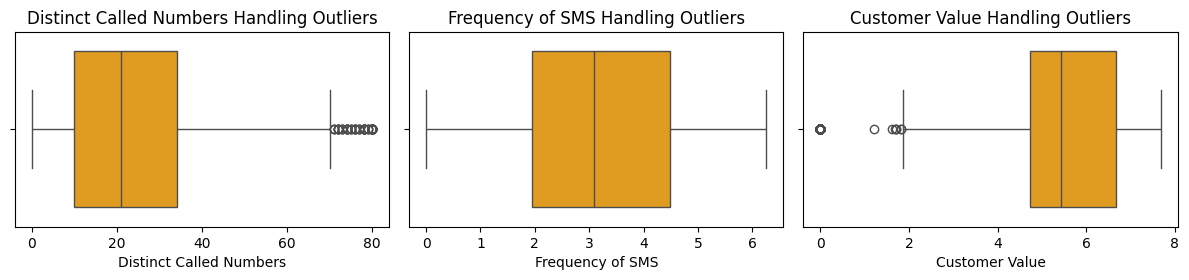

In [ ]:
# Replot the boxplots to check the results after handling outliers
numerical_features = ['Distinct Called Numbers', 'Frequency of SMS', 'Customer Value' ]

plt.figure(figsize=(12, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features) // 3+ 1, 3, i)
    sns.boxplot(x=df[feature], color='orange')
    plt.title(f'{feature} Handling Outliers')
plt.tight_layout()
plt.show()

## Feature Engineering

In [ ]:
#Add new Feature for Network period
bins = [0, 12, 24, 36, 48]  # Define the bin edges
labels = [0, 1, 2, 3]       # Assign ordinal values as labels
df['Tenure Category'] = pd.cut(df['Subscription  Length'], bins=bins, labels=labels, right=False)

In [ ]:
#Add New feature for Usage
df['Usage Consistency'] = df['Frequency of use'] / df['Subscription  Length']
df.head()

,Customer ID,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn,Tenure Category,Usage Consistency
0,1,8,0,38,0,4370,71,1.791759,17.0,3,1,1,30,5.291494,0,3,1.868421
1,2,0,0,39,0,318,5,2.079442,4.0,2,1,2,25,3.850892,0,3,0.128205
2,3,10,0,37,0,2453,60,5.886104,24.0,3,1,1,30,7.337926,0,3,1.621622
3,4,10,0,38,0,4198,66,0.693147,35.0,1,1,1,15,5.484880,0,3,1.736842
4,5,3,0,38,0,2393,58,1.098612,33.0,1,1,1,15,4.989105,0,3,1.526316


In [ ]:
df.to_csv('New-Data.csv')

In [ ]:
new_df = pd.read_csv("New-Data.csv")

In [ ]:
correlation_matrix = df.corr()

correlation_matrix = new_df.corr()
corr_with_target = correlation_matrix['Churn'].abs().sort_values(ascending=False)
print(corr_with_target)

Churn                      1.000000
Complains                  0.532053
Status                     0.498976
Customer Value             0.368943
Frequency of use           0.303337
Seconds of Use             0.298935
Distinct Called Numbers    0.280316
Usage Consistency          0.243169
Frequency of SMS           0.216106
Charge  Amount             0.202305
Tariff Plan                0.105853
Tenure Category            0.051747
Subscription  Length       0.032588
Age                        0.017705
Age Group                  0.014550
Customer ID                0.014456
Unnamed: 0                 0.014456
Call  Failure              0.008987
Name: Churn, dtype: float64


## 3. Feature Selection

In [ ]:
# Drop features with low correlation with Churn (Less than 0.05)
columns_to_drop = ['Subscription  Length','Age','Age Group', 'Call  Failure']  # Update names based on actual column headers
# Remove columns from the dataframe
x_new_df = new_df.drop(columns=columns_to_drop)
x_new_df.head()

,Unnamed: 0,Customer ID,Complains,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Tariff Plan,Status,Customer Value,Churn,Tenure Category,Usage Consistency
0,0,1,0,0,4370,71,1.791759,17.0,1,1,5.291494,0,3,1.868421
1,1,2,0,0,318,5,2.079442,4.0,1,2,3.850892,0,3,0.128205
2,2,3,0,0,2453,60,5.886104,24.0,1,1,7.337926,0,3,1.621622
3,3,4,0,0,4198,66,0.693147,35.0,1,1,5.484880,0,3,1.736842
4,4,5,0,0,2393,58,1.098612,33.0,1,1,4.989105,0,3,1.526316


In [ ]:
x_new_df.to_csv('/content/Final-Data.csv')

##Model Selection

###It is a classification problem, such as predicting customer churn
### Binary classification - churn or no churn
### For Classification problem model choices are -
 ### 1. Decision Tree
 ### 2. Random Forest Classifier
 ### 3. Logistic regression
 ### 4. K-Nearest Neighbors



### Spliting the dataset into training set and testing set

In [ ]:
#Load the Final data
Final_Data = pd.read_csv('/content/Final-Data.csv')

# Split the data into training and test sets
X = Final_Data.drop(columns=['Churn'])  # Features
y = Final_Data['Churn']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Display the shapes of the resulting datasets
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Testing Labels Shape: {y_test.shape}")

Training Features Shape: (2520, 14)
Testing Features Shape: (630, 14)
Training Labels Shape: (2520,)
Testing Labels Shape: (630,)


## Model building and evaluation


In [ ]:
# Initialize models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
}

# Dictionary to store model performance
model_results = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store the results
    model_results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
    }

# Convert the results to a DataFrame for easy comparison
results_df = pd.DataFrame(model_results).T
print(results_df)

                     Accuracy  Precision    Recall  F1-Score
Decision Tree        0.928571   0.809524  0.772727  0.790698
Random Forest        0.928571   0.842105  0.727273  0.780488
Gradient Boosting    0.923810   0.810000  0.736364  0.771429
K-Nearest Neighbors  0.811111   0.384615  0.136364  0.201342


##Confusion matrics

In [ ]:
# Print confusion matrices for each model
for model_name, metrics in model_results.items():
    print(f"\nConfusion Matrix for {model_name}:")
    print(confusion_matrix(y_test, model.predict(X_test)))


Confusion Matrix for Decision Tree:
[[496  24]
 [ 95  15]]

Confusion Matrix for Random Forest:
[[496  24]
 [ 95  15]]

Confusion Matrix for Gradient Boosting:
[[496  24]
 [ 95  15]]

Confusion Matrix for K-Nearest Neighbors:
[[496  24]
 [ 95  15]]


## AUC-ROC curve

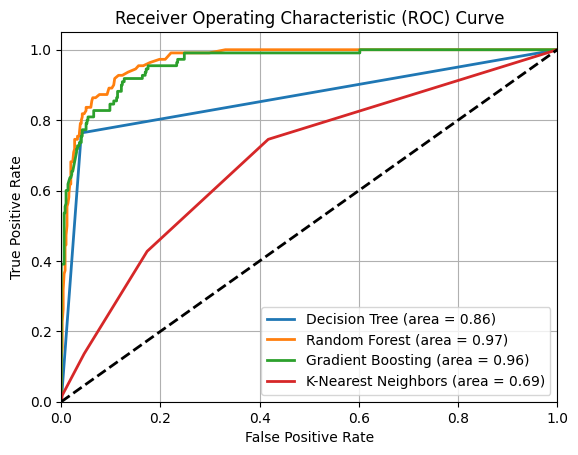

In [ ]:
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict probabilities
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (area = {roc_auc:.2f})')

# Finalize the ROC plot
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Cross-validation

In [ ]:
# Perform cross-validation
cv_results = {} # Initialize the cv_results dictionary

for model_name, model in models.items():
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_score = np.mean(scores)

    # Store the results
    cv_results[model_name] = {
        "Mean Accuracy (Cross_Validation)": mean_score
    }

# Convert the results to a DataFrame for easy comparison
cv_results_df = pd.DataFrame(cv_results).transpose()
print(cv_results_df)

                     Mean Accuracy (Cross_Validation)
Decision Tree                                0.928175
Random Forest                                0.936508
Gradient Boosting                            0.936905
K-Nearest Neighbors                          0.823413


## Reason for Seleting Random Forest Classifier Model
### Random Forest results
### Accuracy  - 0.931746, Precision - 0.852632, Recall - 0.736364, F1-Score - 0.790244, Cross-validation - 0.936508

### Outcomes
### - Random Forest appears to be the best model overall, as it has the highest mean accuracy from cross-validation and good performance in terms of precision and accuracy

### - The Gradient Boosting model also performs well but slightly less consistently compared to Random Forest

### - The Decision Tree has strong performance metrics but slightly lower cross-validation accuracy

### - K-Nearest Neighbors performs significantly worse on most metrics, indicating it might not be the best choice for this problem.
